In [18]:
import numpy as np
from PIL import Image

from triplane import TriPlane

import torch
from camera_utils import LookAtPoseSampler, FOV_to_intrinsics

In [35]:
triplane_model = TriPlane({'depth_resolution': 48, 'depth_resolution_importance': 48, 'ray_start': 2.25, 'ray_end': 3.3, 'box_warp': 1, 'avg_camera_radius': 2.7, 'avg_camera_pivot': [0, 0, 0.2], 'image_resolution': 512, 'disparity_space_sampling': False, 'clamp_mode': 'softplus', 'c_gen_conditioning_zero': False, 'gpc_reg_prob': 0.8, 'c_scale': 1.0, 'density_reg': 0.25, 'density_reg_p_dist': 0.004, 'reg_type': 'l1', 'decoder_lr_mul': 1.0, 'sr_antialias': True})
triplane_model.decoder.load_state_dict(torch.load('eg3d_decoder.pt'))
triplane_model = triplane_model.to('cuda')

In [81]:
@torch.no_grad()
def generate_imgs(triplane, rotation=(3.14/2, 3.14/2), pivot=[0, 0, 0.2], radius=2.7, fov=18, device='cuda'):
        intrinsics = FOV_to_intrinsics(fov)
        
        cam_pivot = torch.tensor(pivot)
        cam2world_pose = LookAtPoseSampler.sample(rotation[0], rotation[1], cam_pivot, radius=radius)
        camera_params = torch.cat([cam2world_pose.reshape(-1, 16), intrinsics.reshape(-1, 9)], 1)
        camera_params = camera_params.to(device)

        triplane = triplane.to(device)
        out = triplane_model.synthesis(triplane, camera_params, 256)
        # imgs = out['image'].detach().cpu().numpy()

        return out

In [82]:
# triplane = torch.rand([1, 96, 256, 256])
triplane = torch.from_numpy(np.load('saved_tp/00.npy')).unsqueeze(0).to('cuda')

In [176]:
out = generate_imgs(triplane, rotation=(3.14*0.5, 3.14*0.25), pivot=[0.3, 0, 0.2])

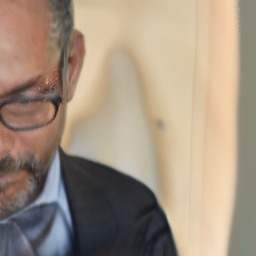

In [177]:
img_arr = out['image'][0].permute(1, 2, 0).cpu().numpy()
img_arr = ((img_arr + 1) / 2 * 255).astype(np.uint8)
img = Image.fromarray(img_arr)
display(img)

In [98]:
img_arr.min(), img_arr.max()

(0, 252)